In [315]:
import sys
sys.path.insert(0, '../../')

from datetime import datetime
from time import perf_counter_ns
from functools import partial
from ssfp import bssfp
import numpy as np
from numpy.linalg import LinAlgError
import matplotlib.pyplot as plt
from gasp import responses, tissue
from gasp.simulation import train_gasp, view_gasp

In [316]:
# x: [alpha, TR, PC]*K
K = 8  # total number of phase-cycles
width = 256
height = 1
gradient = 2.0 * np.pi
phantom_padding = 8
phantom_type = "line"
gasp_method = "linear"
# gasp_method = "lev-mar-quad"
desired_funs = []

RES_LOG_NAME = "opt-res.log"
with open(RES_LOG_NAME, "w") as fp:
    fp.write(f"Run {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    fp.write(f"params: K({K}), width({width}), height({height}), gradient({gradient}), phantom_padding({phantom_padding}), phantom_type({phantom_type})\n")
    fp.write("desired_funs:\n")
    for shift in (-.25, 0, .25, .5):
        desired_funs.append(responses.square(width, bw=0.3, shift=shift))
        fp.write(f"    responses.square(width, bw=0.3, shift={shift})\n")

# mask desired funs
for ii in range(len(desired_funs)):
    desired_funs[ii][:phantom_padding] = 0
    desired_funs[ii][-phantom_padding:] = 0


In [317]:
x0 = np.empty(3*K, dtype=float)

x0[0::3] = np.deg2rad(60)

x0[1::3][:K//3] = 5e-3
x0[1::3][K//3:2*K//3] = 10e-3
x0[1::3][2*K//3:] = 12e-3

x0[2::3][:K//3] = np.linspace(0, 2*np.pi, K//3, endpoint=False)
x0[2::3][K//3:2*K//3] = np.linspace(0, 2 * np.pi, len(x0[2::3][K//3:2*K//3]), endpoint=False)
x0[2::3][2*K//3:] = np.linspace(0, 2 * np.pi, len(x0[2::3][2*K//3:]), endpoint=False)

print(np.reshape(x0, (K, 3)))

[[1.04719755 0.005      0.        ]
 [1.04719755 0.005      3.14159265]
 [1.04719755 0.01       0.        ]
 [1.04719755 0.01       2.0943951 ]
 [1.04719755 0.01       4.1887902 ]
 [1.04719755 0.012      0.        ]
 [1.04719755 0.012      2.0943951 ]
 [1.04719755 0.012      4.1887902 ]]


In [318]:
t = tissue.tissue_generator(type=phantom_type, padding=phantom_padding)
mask = t['mask']
size = mask.shape
t1 = t['t1']
t2 = t['t2']

lowest_cost = 1e9
lowest_cost_solution = None
cost_history = []

def cost(x, _K: int, desired_funs, _width: int, _height: int, _gradient: float, _gasp_method: str, disp: bool = False) -> float:
    global lowest_cost, cost_history, lowest_cost_solution

    alphas = x[0::3]
    TRs = x[1::3]
    PCs = x[2::3]
    
    BetaMax = _gradient
    beta = np.linspace(-BetaMax, BetaMax, size[1])
    minTR = min(TRs)
    f = beta / minTR / (2 * np.pi)
    f = np.tile(f, (size[0], 1))
    
    M = bssfp(T1=t1, T2=t2, TR=TRs, alpha=alphas, field_map=f, phase_cyc=PCs)
    if np.isnan(M).any():
        raise ValueError("produced NaN:", alphas, TRs, PCs)

    # for ii in range(_K):
    #     alpha = x[ii*3]
    #     TR = x[ii*3+1]
    #     PC = float(x[ii*3+2])
    #     # print(np.rad2deg(alpha), TR*1000, np.rad2deg(PC))
    #     M.append(simulate_ssfp(
    #         width=_width,
    #         height=_height,
    #         pcs=[PC],
    #         TRs=(TR,),
    #         alpha=alpha,
    #         gradient=_gradient,
    #         phantom_type=_phantom_type,
    #         minTR=min(x[1::3]),
    #         useSqueeze=False,
    #     ))

        # plt.imshow(np.abs(M[-1].squeeze()))
        # plt.title(f"{ii} PC")
        # plt.show()

    #for ii in range(_K):
    #    plt.plot(np.abs(M[ii, ...]))
    #plt.show()
    
    # M = np.concatenate(M, axis=-1)
    M = M.T
    M = M[None, ...]  # add width
    M = np.expand_dims(M, axis=2)  # add coil
    M = M[..., None]
    # print(M.shape)
    # view_gasp_input(M=M)
    res = 0.0
    for ii, desired_fun in enumerate(desired_funs):
        Ic, An = train_gasp(M=M, D=desired_fun, method=_gasp_method)
        err = np.linalg.norm(desired_fun - Ic[_height // 2, :])**2
        res += err

        if disp:
            # for desired_fun in desired_funs:
                # view_gasp(Ic[_height // 2, :], D=desired_funs)
            plt.plot(desired_fun, "k-", label=f"Desired func {ii+1}/{len(desired_funs)}")
            plt.plot(Ic[_height // 2, :], "--", label="GASP fit")
            plt.title(f"Error: {err}")
            plt.legend()
            plt.show()
    # assert False

    # plt.plot(desired_fun, "k-")
    # plt.plot(Ic[_width // 2, :], "--")
    # plt.show()
    # print(res)

    if res < lowest_cost:
        with open(RES_LOG_NAME, "a") as fp:
            towrite = np.reshape(x, (-1, 3))
            fp.write(f"cost: {res}\n" + str(towrite) + "\n")
        lowest_cost = res
        lowest_cost_solution = x

    #print(res, np.rad2deg(x[0::3]), 1000*x[1::3], np.rad2deg(x[2::3]))
    cost_history.append(res)
    return res

bnds = []
for ii in range(K):
    bnds.append((np.deg2rad(3), np.deg2rad(100)))
    bnds.append((3e-3, 30e-3))
    bnds.append((0, 2*np.pi))

cost_fun = partial(cost, _K=K, desired_funs=desired_funs, _width=width, _height=height, _gradient=gradient, _gasp_method=gasp_method)

#print(f"FIRST GUESS IS {cost_fun(x0)}")

In [319]:
t0 = perf_counter_ns()
try:

    # works quickly and well for small numbers of PCs
    from scipy.optimize import direct
    def clbk(xk):
        print(cost_fun(xk))
    
    res = direct(
        func=cost_fun,
        bounds=bnds,
        callback=clbk,
    )
    
    # # doesn't work well as it violates bounds (because it can't have any...) and produces NaNs 
    # from scipy.optimize import basinhopping
    # res = basinhopping(
    #     func=cost_fun,
    #     x0=x0,
    #     disp=True,
    # )
    
    # # doesn't seem to work well for this problem
    # from scipy.optimize import shgo
    # def clbk(xk):
    #     print(cost_fun(xk))
    
    # res = shgo(
    #     func=cost_fun,
    #     bounds=bnds,
    #     options={"disp": True},
    #     # workers=8,
    #     callback=clbk,
    # )
    
    # # slow, but good for higher numbers of PCs
    # from scipy.optimize import dual_annealing
    # def clbk(x, f, context):
    #     print(f)
    
    # res = dual_annealing(
    #     func=cost_fun,
    #     x0=x0,
    #     bounds=bnds,
    #     callback=clbk,
    # )
except KeyboardInterrupt:
    print("User stopped optimization prematurely")

print(f"DONE IN {(perf_counter_ns() - t0)/1e9} SECONDS")


84.0107623833305
46.14742371647997
25.688623062453114
21.76695352843253
19.540937316739026
18.21408998803064
67.97388820713783
68.16992692317504
69.36798510720106
66.92900281958565
68.01409723075048
67.28023440934612
69.29587202757192
10.82191625523881
10.590566138372871
10.032249090607984
9.918251301317675
DONE IN 10.06488668 SECONDS


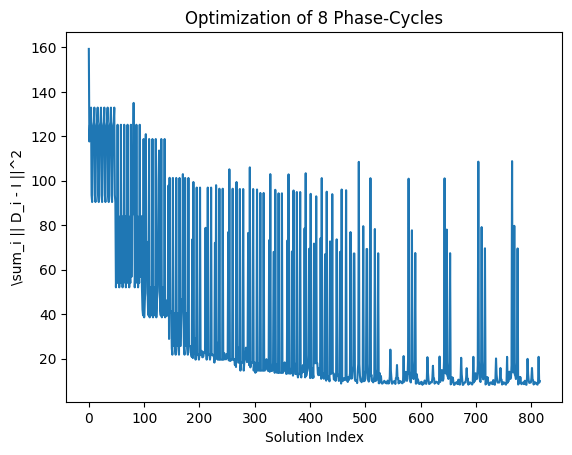

In [320]:
plt.plot(cost_history)
plt.title(f"Optimization of {K} Phase-Cycles")
plt.xlabel("Solution Index")
plt.ylabel("\sum_i || D_i - I ||^2")
plt.show()

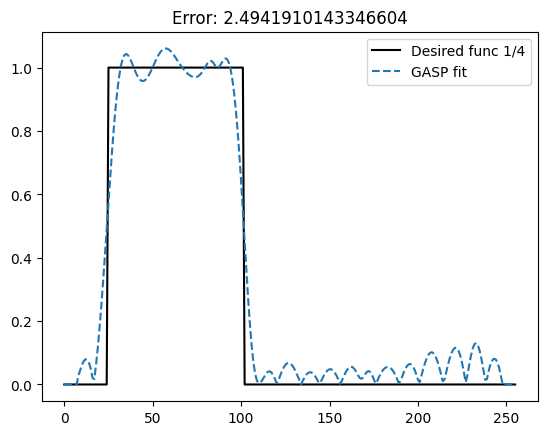

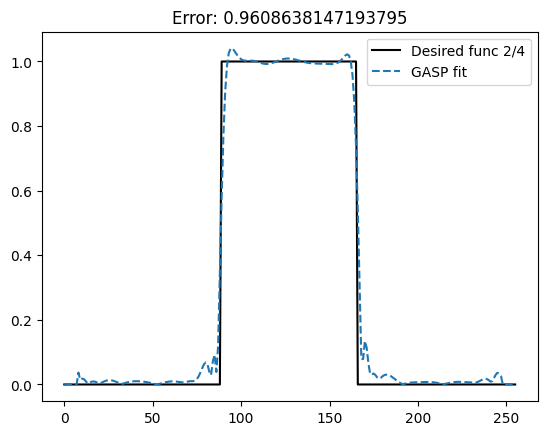

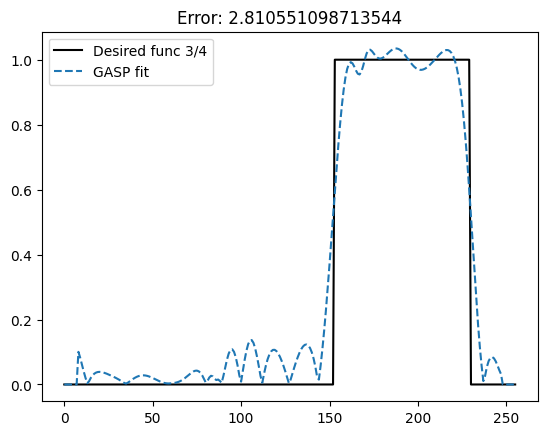

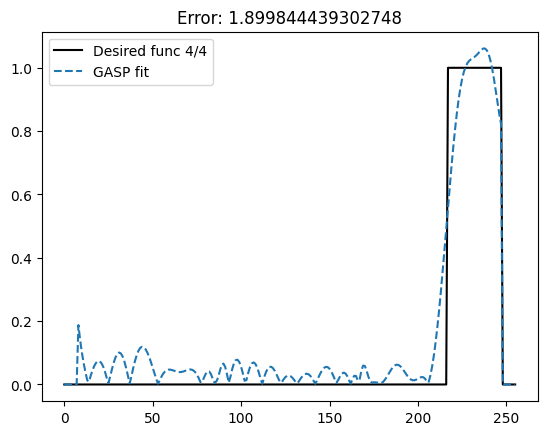

8.165450367070333

In [321]:
cost_fun(x=lowest_cost_solution, disp=True)